In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

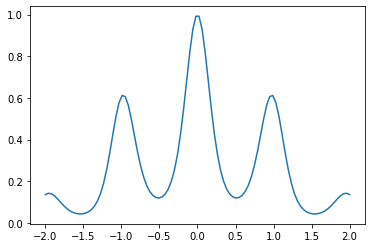

In [2]:
from sklearn.gaussian_process import kernels as sk_kern

kern = sk_kern.RBF(length_scale=.5)
kern = sk_kern.ExpSineSquared() * sk_kern.RBF()
X = np.linspace(-2, 2, 100)
plt.plot(X, kern(X.reshape(-1, 1), np.array([[0.]])))



In [3]:
df = pd.read_csv("Simulated.csv", sep=',', header=None)
x_train = df[0].values
y_train = df[1].values


In [4]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

In [5]:
def model_poly(x_train, y_train=0):
    α1 = numpyro.sample("α1", dist.Normal(0.0, 5.0))
    α2 = numpyro.sample("α2", dist.Normal(0.0, 5.0))
    α3 = numpyro.sample("α3", dist.Normal(0.0, 5.0))
    α4 = numpyro.sample("α4", dist.Normal(0.0, 5.0))
    α5 = numpyro.sample("α5", dist.Normal(0.0, 5.0))
    α0 = numpyro.sample("α0", dist.Normal(0.0, 5.0))

    sc = numpyro.sample('sc', dist.HalfNormal(5) )

    mu = α0 + α1 * x_train +  α2 * x_train**2 + α3 * x_train**3 + α4 * x_train**4 + α5 * x_train**5 
    
    with numpyro.plate("N", len(x_train)):
        numpyro.sample('obs', dist.Normal(mu, sc),  obs = y_train)

In [6]:
nuts = numpyro.infer.NUTS(model_poly)

mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), x_train, y_train)

trace = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

<ipython-input-6-d64d3d7137a2>:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)
sample: 100%|██████████| 3500/3500 [00:02<00:00, 1587.74it/s, 511 steps of size 6.79e-03. acc. prob=0.94] 


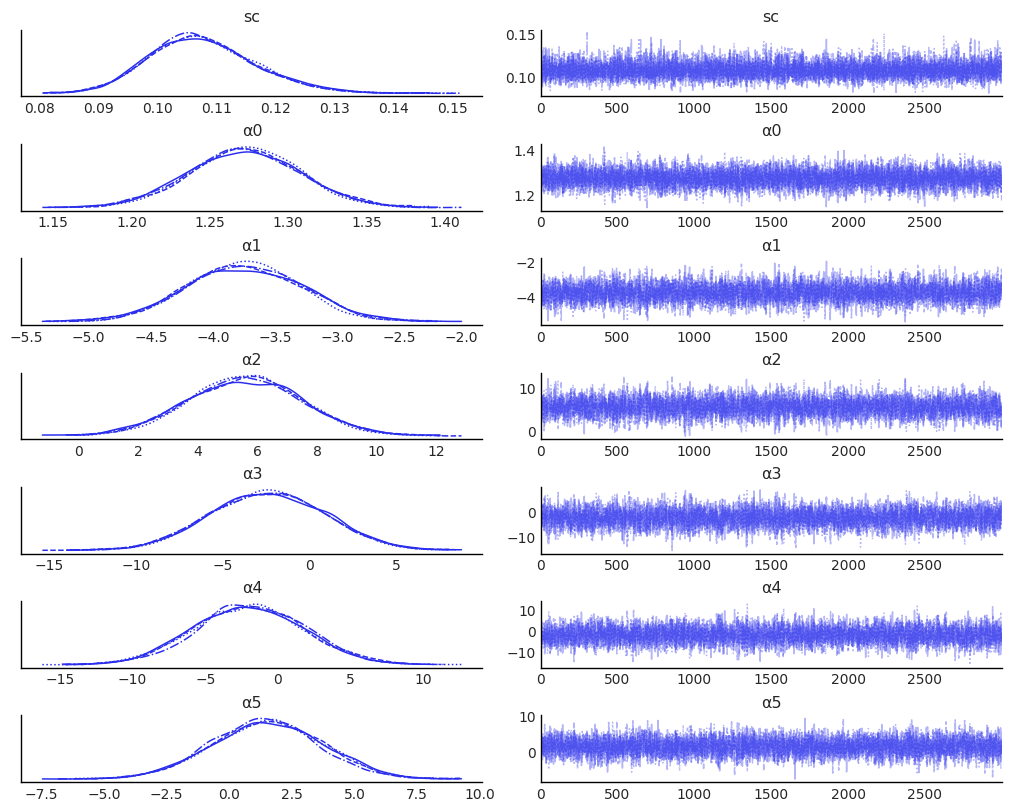

In [7]:
az.style.use("arviz-white")
az.plot_trace(idata,figsize=(10, 8));

In [8]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sc,0.108,0.009,0.091,0.125,0.000,0.000,7653.0,6765.0,1.0
α0,1.273,0.035,1.208,1.341,0.000,0.000,5719.0,5747.0,1.0
α1,-3.744,0.468,-4.634,-2.894,0.008,0.005,3753.0,5075.0,1.0
α2,5.579,1.942,1.914,9.209,0.032,0.023,3588.0,4709.0,1.0
α3,-2.409,3.314,-8.569,3.726,0.054,0.039,3725.0,4961.0,1.0
α4,-1.959,3.753,-8.865,5.132,0.056,0.040,4473.0,4855.0,1.0
α5,1.510,2.186,-2.671,5.494,0.031,0.022,4989.0,6461.0,1.0


In [9]:
import jax.numpy as jnp 

X_range = jnp.linspace(0, 1, 1000)

predictive_poly5 = numpyro.infer.Predictive(model_poly, trace)
ppc_samples_poly5  = predictive_poly5(jax.random.PRNGKey(1), X_range, None)
idata_ppc_poly5 = az.from_numpyro(mcmc, posterior_predictive=ppc_samples_poly5)

In [11]:
df_ppc_poly5 = pd.DataFrame()
df_ppc_poly5["X"]=X_range
df_ppc_poly5["Y_pred"] = ppc_samples_poly5["obs"].T.mean(axis=1)
df_ppc_poly5["sigma"] = ppc_samples_poly5["obs"].T.std(axis=1)
df_ppc_poly5["Y_inf"] = df_ppc_poly5["Y_pred"] - df_ppc_poly5["sigma"]
df_ppc_poly5["Y_sup"] = df_ppc_poly5["Y_pred"] + df_ppc_poly5["sigma"]

In [14]:
df_ex_coloc_full = pd.read_csv('Coloc_Exclusion_Rate.csv').T.reset_index()
df_ex_sep_full = pd.read_csv('Sep_Exclusion_Rate.csv').T.reset_index()

df_ex_coloc = df_ex_coloc_full[0:3]
df_ex_sep = df_ex_sep_full[2:5]

xcoloc = df_ex_coloc['index'].values.astype(float)
ycoloc = df_ex_coloc[0].values

xsep = np.zeros(df_ex_sep.shape[0])
ysep = df_ex_sep[0].values

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, *, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

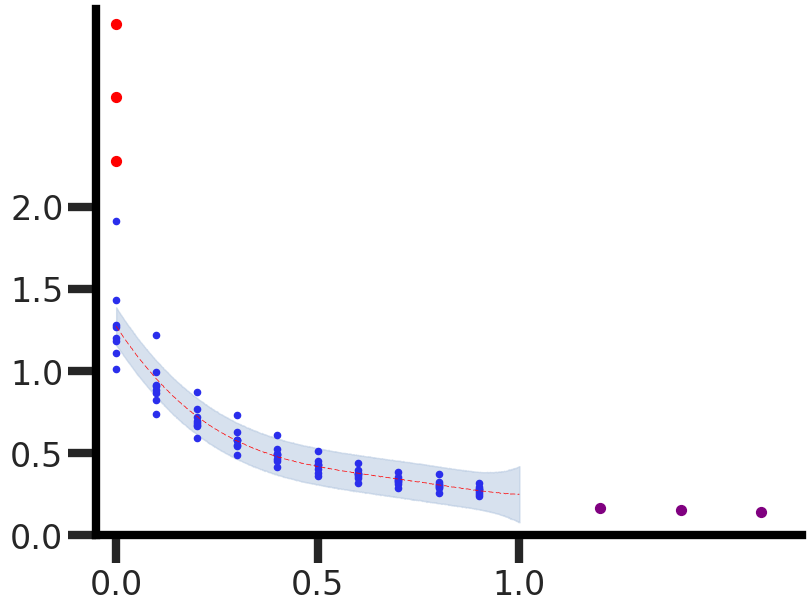

In [15]:
x_ppc_poly5 = df_ppc_poly5["X"].values

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(1,1,1)

plt.plot(x_ppc_poly5, df_ppc_poly5["Y_pred"].values, lw=0.5, alpha=1, color="red", linestyle="dashed", dashes=[8,4])
plt.fill_between(x_ppc_poly5, df_ppc_poly5["Y_inf"], df_ppc_poly5["Y_sup"], alpha=0.5, color="lightsteelblue")
plt.scatter(x_train, y_train, s=20)



# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(6)

# increase tick width
ax1.tick_params(width=6, length = 20, labelsize=24)
ax1.tick_params(which='minor', width=3, length=10)

ax1.set_xlim(-0.05, 1.7)
ax1.set_ylim(0, 3.2)
ax1.set_xticks([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1, 1.5, 2.0])


plt.scatter(xsep, ysep, s=50, color='red')
plt.scatter(xcoloc, ycoloc, s=50, color='purple')

plt.figure
